## Introduction

In this laboratory we will implement what is called in the literature a Cycle GAN (https://arxiv.org/pdf/1703.10593.pdf). These are powerful models that can learn to translate images without having paired samples to learn from.

A Generative Adversarial Network can generate novel data that is similar to that found in the training set (comes from the same distribution). As you've seen in the lecture, classic models can take random noise as input and learn to generate such data. There are also models where, in addition to the random noise, the model can take another input which it is meant to translate. For instance, this paper https://arxiv.org/pdf/1611.07004.pdf showcases translating images containing outlines alone to fully fledged objects.

![](./edge_to_obj_.png)

In such cases, there are pairs of desired inputs and outputs. However, it is rarely the case that we can create or benefit from such well structured datasets. The general case consists in samples gathered separately from the two classes that we wish to translate. For instance you can have several images of horses, and several images of zebras with no way of pairing them.

![](./h2z.png)

A CycleGAN can learn to translate from one class to another given such a scenario.

## CycleGAN

A CycleGAN primarily consists in have two GAN models: one that translates from the first class to the second, and one that translates from the second class to the first. Lets name those classes X and Y.

There will be a generator that takes as input an image from the X class and outputs an image from the Y class, a discrimiator that has to distinguish real Y images from fake ones, a generator that translates from Y to X and a final distriminator that classifies real and fake X images.

In order to prevent the generators to output a single image from the opposite class regardless of the input there is an additional factor that the model has to optimize; the most important aspect of the architecture. The translations have to be cycle consistent. This means that if we take an X image and translate it into a Y image, and then translate it again into an X image, we should end up with the exact same image we started with. This is the fundamental ideea of this model.

![](./cycle.png)

Additionally, we will introduce another loss term. Given a X image, we what that the generator that translates from Y to X to exactly reproduce it (identity loss), similarly, the other way around.

## Implemenatation

With the help of your superviser you can implement a CycleGAN starting from this code skeleton. The example featured will be translating apples to oranges, this is so that a model trained for a few iterations can provide visually interesting results. The same model cand then be applied to the zebras to horses dataset, provided you train the model for a larger number of iterations, all you have to do is replace the 'apple2orange' dataset name to 'horse2zebra'. The script will load that dataset and train the model on it without any other changes required.

Firstly, importing all neccessary tools and loading the dataset.

In [1]:
import os
import torch
import torch.nn as nn
from torch import Tensor
import torchvision
from torchvision.transforms.v2 import ToDtype, Compose, Resize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Transform
from torchvision.io import read_image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightning as tl
import kornia as k
import kornia.augmentation as ka
import torch.utils.data as data
import typing as t
import pathlib as pb
from glob import glob
from urllib.request import urlopen
import zipfile
from lightning.pytorch.callbacks import ModelCheckpoint, ModelSummary


torch.set_float32_matmul_precision('medium')

In [2]:
class Apple2OrangeDataset(data.Dataset):
    def __init__(self,
                 split: t.Literal['train', 'test'],
                 kind: t.Literal['apple', 'orange'],
                 root: pb.Path = pb.Path('.'),
                 download: bool=True) -> None:
        super().__init__()
        self.name = 'apple2orange'
        self.root: pb.Path = root
        self.split: t.Literal['train', 'test'] = split
        self.kind: t.Literal['apple', 'orange'] = kind
        self.skind: t.Literal['A', 'B'] = 'A' if kind == 'apple' else 'B'
        self.path_to_images = root / self.name / f'{split}{self.skind}'
        self.download(self.root, self.name, download)
        self.transform = Apple2OrangeDataset.create_transforms(split)
        self.images_paths = glob(str(self.path_to_images) + '/' + '*.jpg')

    def __getitem__(self, key: int) -> Tensor:
        image: Tensor = read_image(self.images_paths[key], torchvision.io.ImageReadMode.RGB)
        image = self.transform(image)
        return image

    def __len__(self) -> int:
        return len(self.images_paths)

    @staticmethod
    def download(root: pb.Path, dataset: str, download: bool):
        if not download:
            return
        if pb.Path(root, dataset).exists():
            return
        url: str = f'https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{dataset}.zip'
        zip_path = pb.Path(root, f'{dataset}.zip')
        with urlopen(url) as res, open(str(zip_path), 'wb') as f:
            f.write(res.read())
        with zipfile.ZipFile(zip_path) as zip:
            zip.extractall(root)
        os.remove(zip_path)

    @staticmethod
    def create_transforms(split: t.Literal['train', 'test']) -> Transform:
        transform = []
        if split == 'train':
            transform.append(Resize([286, 286], antialias=True))
            transform.append(RandomCrop([256, 256]))
            transform.append(RandomHorizontalFlip())
            transform.append(RandomVerticalFlip())
        transform.append(ToDtype(torch.float32, scale=True))
        return Compose(transform)

Use PyTorch Lightning for creating mixed data batches

In [3]:
class Apple2OrangeDataModule(tl.LightningDataModule):
    def __init__(self,
                 root: str,
                 batch_size: int,
                 num_workers: int = 2,
                 prefetch_factor: int | None = 2,
                 pin_memory: bool = True) -> None:
        super(Apple2OrangeDataModule, self).__init__()
        self.root = pb.Path(root)
        self.batch_size = batch_size
        self.pin_memory = pin_memory
        self.num_workers = num_workers
        self.prefetch_factor = prefetch_factor

    def prepare_data(self) -> None:
        Apple2OrangeDataset.download(self.root, 'apple2orange', download=True)

    def setup(self, stage: str):
        match stage:
            case 'fit':
                self.train_x = Apple2OrangeDataset('train', 'apple', self.root, False)
                self.train_y = Apple2OrangeDataset('train', 'orange', self.root, False)
            case 'test':
                self.test_x = Apple2OrangeDataset('test', 'apple', self.root, False)
                self.test_y = Apple2OrangeDataset('test', 'orange', self.root, False)
            case _:
                raise ValueError('no data for stage {0}'.format(stage))

    def train_dataloader(self) -> t.List[data.DataLoader[Tensor]]:
        train_x_dl = data.DataLoader(self.train_x, batch_size=self.batch_size, num_workers=self.num_workers, prefetch_factor=self.prefetch_factor, pin_memory=self.pin_memory)
        train_y_dl = data.DataLoader(self.train_y, batch_size=self.batch_size, num_workers=self.num_workers, prefetch_factor=self.prefetch_factor, pin_memory=self.pin_memory)
        return [train_x_dl, train_y_dl]

    def test_dataloader(self) -> t.List[data.DataLoader[Tensor]]:
        test_x_dl = data.DataLoader(self.test_x, batch_size=self.batch_size, num_workers=self.num_workers, prefetch_factor=self.prefetch_factor, pin_memory=self.pin_memory)
        test_y_dl = data.DataLoader(self.test_y, batch_size=self.batch_size, num_workers=self.num_workers, prefetch_factor=self.prefetch_factor, pin_memory=self.pin_memory)
        return [test_x_dl, test_y_dl]

Now, we will define our generator architecture. For this class we will use a simple U-Net generator. The ideea is to concatenate the convolutional features in the following manner.

![](./unet.jpg)

For instance, if your first layer has 32 filters, your last layer (excluding the final output) that will also have 32 layers, will be contatenated with the first one obtaining 64 channels as input for what follows. Another example suppose you have an architecture with the following number of filters: input -> 32 -> 64 -> 128 -> 64 -> 32 -> 3(final output). Then, the final 32-filter convolution output will have its output concatened with the output of the first 32-filter convolution, and the last 64-filter convolution will have its output concatenated with that of the first 64-filter convolution output. The reason for this is that the generators have to reconstruct pretty much the same visual structure they received as input so instead of having the task of memorizing the structure, we will simply give the the structure for it as it advances in its reconstruction.

Our final layer will have sigmoid activation in order to reconstruct the input.

In [4]:
class Block(nn.Module):
    def __init__(self,
                 input_channels: int,
                 output_channels: int,
                 input_size: t.Literal['reduce', 'expand'] | None = None,
                 output_size: t.Literal['reduce', 'expand'] | None = None) -> None:
        super(Block, self).__init__()
        self.layers = nn.Sequential()

        match input_size:
            case 'reduce':
                self.layers.append(nn.MaxPool2d((2, 2), 2))
            case 'expand':
                self.layers.append(nn.ConvTranspose2d(input_channels, input_channels, 2, 2, 0))

        self.layers.append(nn.Conv2d(input_channels, output_channels, 3, 1, 1))
        self.layers.append(nn.InstanceNorm2d(output_channels))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Conv2d(output_channels, output_channels, 3, 1, 1))
        self.layers.append(nn.InstanceNorm2d(output_channels))
        self.layers.append(nn.LeakyReLU())

        match output_size:
            case 'reduce':
                self.layers.append(nn.MaxPool2d((2, 2), 2))
            case 'expand':
                self.layers.append(nn.ConvTranspose2d(output_channels, output_channels, 2, 2, 0))

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)


class Generator(nn.Module):
    def __init__(self, ) -> None:
        super(Generator, self).__init__()

        self.encoder = nn.ModuleList([
            Block(  3,  64),
            Block( 64, 128, input_size='reduce'),
            Block(128, 256, input_size='reduce'),
            Block(256, 512, input_size='reduce'),
        ])

        self.bottleneck = Block(512, 1024, input_size='reduce', output_size='expand')

        self.decoder = nn.ModuleList([
            Block(1024 + 512, 512, output_size='expand'),
            Block( 512 + 256, 256, output_size='expand'),
            Block( 256 + 128, 128, output_size='expand'),
            Block( 128 +  64,  64),
        ])

        self.outlayer = nn.Conv2d(64, 3, 1, 1, 0)
        self.activ_fn = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        r: t.List[Tensor] = []

        # Encode the input
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            r.append(x)
        r.reverse()

        # Apply bottleneck
        x = self.bottleneck(x)

        # Decode the activation maps
        for i, layer in enumerate(self.decoder):
            x = layer(torch.cat([r[i], x], dim=1))

        x = self.outlayer(x)
        x = self.activ_fn(x)
        return x

For the discrminator, since its will not have a complicated architecture, it will suffice to define a function that returns a sequential layer.

In [5]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            Block(  3,  64, output_size='reduce'),
            Block( 64, 128, output_size='reduce'),
            Block(128, 256, output_size='reduce'),
            Block(256, 512, output_size='reduce'),
        )

        self.dense_layers = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        x =  self.conv_layers(x)
        x = self.dense_layers(x)
        return x

We will instantiate all models and define their individual optimizers

The complex part comes next, defining the fit_iteration function. If you think it thoroughly, take it step by step and work with your supervisor, it should come naturally. As a special mention, whenever using gradient taping you should perform **all** (loss) computations within the context. Outside the context should only be gradient applications.

In [6]:
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
from lightning.pytorch.core.optimizer import LightningOptimizer
import torch.nn.functional as F


class CycleGAN(tl.LightningModule):
    def __init__(self) -> None:
        super(CycleGAN, self).__init__()

        # Optimization is more complex so we do it manually
        self.automatic_optimization = False

        # Models
        self.gen_x_y = Generator()
        self.gen_y_x = Generator()
        self.dis_x = Discriminator()
        self.dis_y = Discriminator()

    def training_step(self, batch: t.List[Tensor], batch_idx: t.Any) -> None:
        # Retrieve an optimizer for each model
        gxy_opt, gyx_opt, dx_opt, dy_opt = t.cast(t.List[LightningOptimizer], self.optimizers())

        # Retrieve batches from both subsets of data
        real_x, real_y = batch

        # Generators applied on the real images
        fake_y: Tensor = self.gen_x_y(real_x)
        fake_x: Tensor = self.gen_y_x(real_y)

        # Generators applied on the fake images (cycling)
        cycle_x: Tensor = self.gen_y_x(fake_y)
        cycle_y: Tensor = self.gen_x_y(fake_x)

        # Generators applied for reconstructions (i.e. gen_x_y(real_y)) for the identity loss
        same_x: Tensor = self.gen_y_x(real_x)
        same_y: Tensor = self.gen_x_y(real_y)

        # Compute probabilities according to discriminators
        prob_fake_x: Tensor = self.dis_x(fake_x.detach())
        prob_real_x: Tensor = self.dis_x(real_x)
        prob_fake_y: Tensor = self.dis_y(fake_y.detach())
        prob_real_y: Tensor = self.dis_y(real_y)

        # Labels used to compute losses
        label_real = torch.ones_like(prob_real_x, device=self.device)
        label_fake = torch.zeros_like(prob_fake_x, device=self.device)

        # Compute adversarial discriminator losses using MeanBCELoss
        loss_dx_fake = F.binary_cross_entropy(prob_fake_x, label_fake)
        loss_dx_real = F.binary_cross_entropy(prob_real_x, label_real)
        loss_dx = loss_dx_fake + loss_dx_real
        loss_dy_fake = F.binary_cross_entropy(prob_fake_y, label_fake)
        loss_dy_real = F.binary_cross_entropy(prob_real_y, label_real)
        loss_dy = loss_dy_fake + loss_dy_real

        # Apply gradients for D_x
        dx_opt.zero_grad()
        self.manual_backward(loss_dx)
        dx_opt.step()

        # Apply gradients for D_y
        dy_opt.zero_grad()
        self.manual_backward(loss_dy)
        dy_opt.step()

        # Compute adversarial generator losses using MeanBCELoss
        loss_gyx = F.binary_cross_entropy(self.dis_x(fake_x), label_real)
        loss_gxy = F.binary_cross_entropy(self.dis_y(fake_y), label_real)

        # Compute cycle consistency losses using L1
        loss_cycle_xyx = F.l1_loss(cycle_x, real_x)
        loss_cycle_yxy = F.l1_loss(cycle_y, real_y)
        loss_cycle = loss_cycle_xyx + loss_cycle_yxy

        # Compute identity losses using L1
        loss_identity_x = F.l1_loss(same_x, real_x)
        loss_identity_y = F.l1_loss(same_y, real_y)

        # Apply CycleGAN Generative losses
        gxy_opt.zero_grad()
        gyx_opt.zero_grad()
        self.manual_backward(loss_cycle, retain_graph=True)
        self.manual_backward(loss_gxy, inputs=list(self.gen_x_y.parameters()))
        self.manual_backward(loss_gyx, inputs=list(self.gen_y_x.parameters()))
        self.manual_backward(loss_identity_x)
        self.manual_backward(loss_identity_y)
        gxy_opt.step()
        gyx_opt.step()

    def predict_step(self, batch: t.List[Tensor], batch_idx: t.Any) -> t.Tuple[Tensor, Tensor]:
        # Retrieve batches from both subsets of data
        real_x, real_y = batch
        fake_x: Tensor = self.gen_x_y(real_x)
        fake_y: Tensor = self.gen_y_x(real_y)
        return (fake_x, fake_y)

    def configure_optimizers(self) -> OptimizerLRScheduler:
        gxy_opt = torch.optim.Adam(self.gen_x_y.parameters(), lr=2e-4, betas=(0.4, 0.999))
        gyx_opt = torch.optim.Adam(self.gen_y_x.parameters(), lr=2e-4, betas=(0.4, 0.999))
        dx_opt = torch.optim.Adam(self.dis_x.parameters(), lr=2e-4, betas=(0.4, 0.999))
        dy_opt = torch.optim.Adam(self.dis_y.parameters(), lr=2e-4, betas=(0.4, 0.999))
        return [gxy_opt, gyx_opt, dx_opt, dy_opt]

Perform Training Loop

In [7]:
# Use Apple2Orange Dataset
dataset = Apple2OrangeDataModule('.', 1, num_workers=2, prefetch_factor=1, pin_memory=True)

# Create CycleGAN model
cycle_gan = CycleGAN()

# Inspect & save model periodically across training
ckpt_callback = ModelCheckpoint(dirpath=pb.Path('checkpoints', 'train'), filename='cyclegan')

# Run for 500 steps
trainer = tl.Trainer(
    logger=False,
    max_steps=500 * 8,
    enable_checkpointing=True,
    callbacks=[ckpt_callback],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(cycle_gan, datamodule=dataset)

/home/invokariman/.cache/pypoetry/virtualenvs/lab5-1qVvyCMZ-py3.11/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/train exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | gen_x_y | Generator     | 37.0 M
1 | gen_y_x | Generator     | 37.0 M
2 | dis_x   | Discriminator | 4.8 M 
3 | dis_y   | Discriminator | 4.8 M 
------------------------------------------
83.5 M    Trainable params
0         Non-trainable params
83.5 M    Total params
334.148   Total estimated model params size (MB)


Epoch 0:  98%|█████████▊| 1000/1019 [01:51<00:02,  8.97it/s]

`Trainer.fit` stopped: `max_steps=4000` reached.


Epoch 0:  98%|█████████▊| 1000/1019 [01:52<00:02,  8.90it/s]


Evaluate

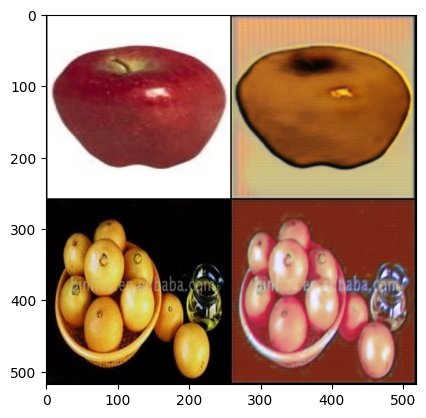

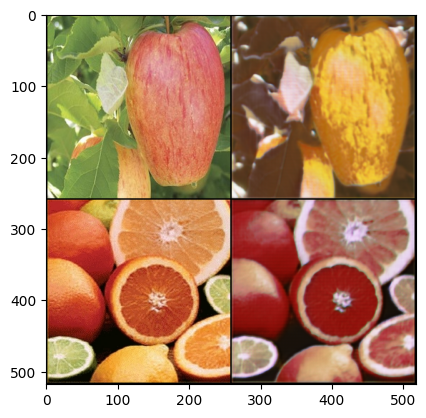

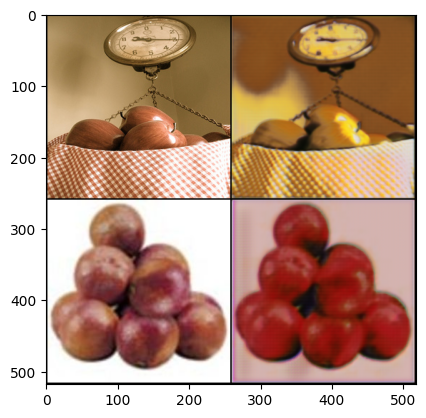

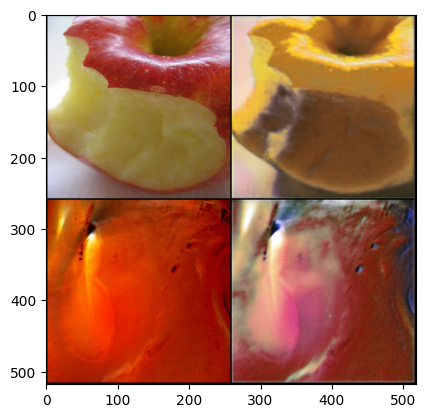

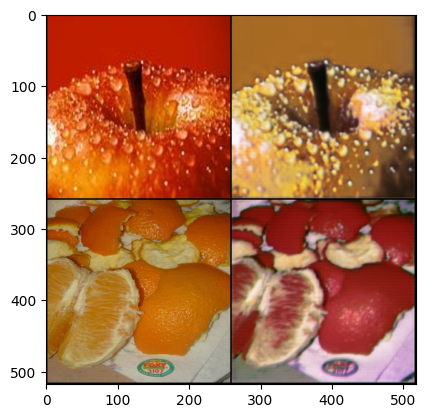

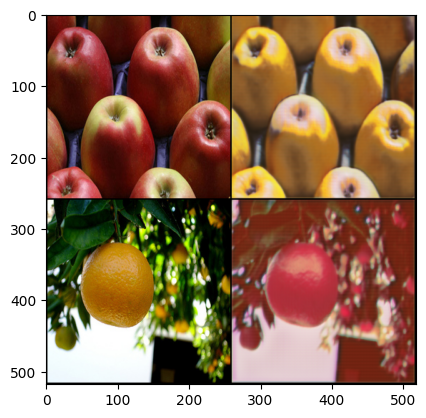

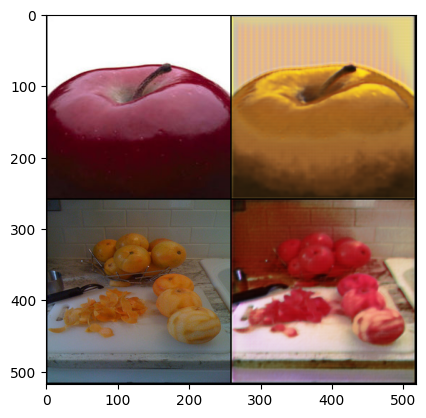

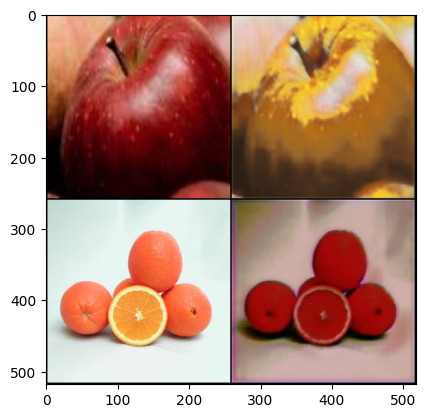

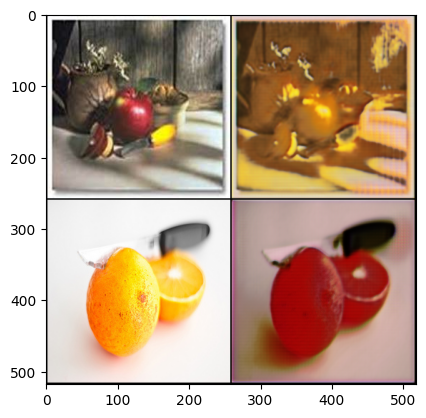

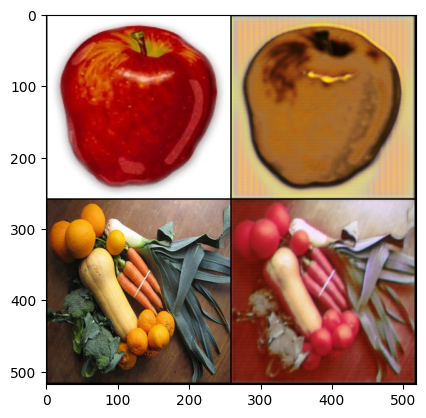

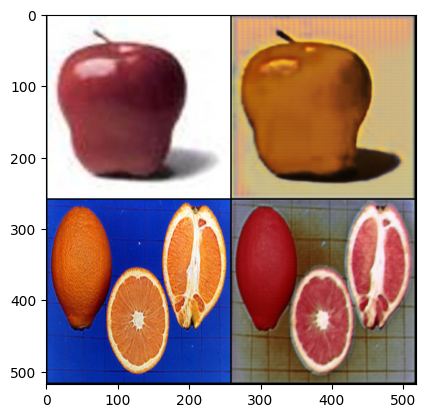

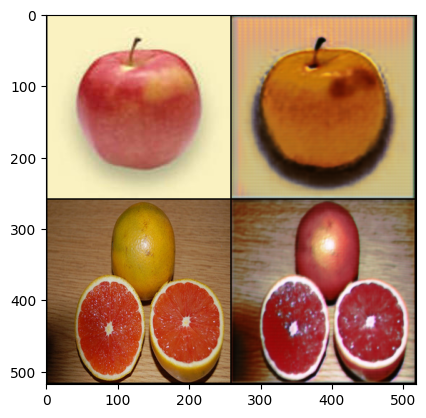

In [13]:
# Load already trained model
cycle_gan = CycleGAN.load_from_checkpoint(pb.Path('checkpoints', 'train', 'cyclegan.ckpt'))
cycle_gan = cycle_gan.eval().requires_grad_(False).cpu()

# Retrieve Test Data
dataset = Apple2OrangeDataModule('.', 1, 0, None, False)
dataset.prepare_data()
dataset.setup('test')
test_x, test_y = dataset.test_dataloader()
test_x, test_y = iter(test_x), iter(test_y)

for _ in range(12):
    real_x, real_y = next(test_x), next(test_y)
    fake_x, fake_y = cycle_gan.gen_y_x(real_y), cycle_gan.gen_x_y(real_x)
    image = torchvision.utils.make_grid(torch.cat([real_x, fake_y, real_y, fake_x]), nrow=2)
    plt.imshow(image.permute((1, 2, 0)))
    plt.show()

The complex part comes next, defining the fit_iteration function. If you think it thoroughly, take it step by step and work with your supervisor, it should come naturally. As a special mention, whenever using gradient taping you should perform **all** (loss) computations within the context. Outside the context should only be gradient applications.